## Warping a Triangle

- Overview
- Linear Transform
- Nonlinear Transforms
- Approximating Nonlinear Transforms using Piecewise Linear Transforms
- Warp Triangle Code

# Linear or Affine Transform

1. Translation
2. Scale
3. Rotation
4. Shear

![](data/images/linear-transforms.jpg)

$$x_0 = ax_i + by_i + t_x$$
$$y_0 = cx_i + dy_i + t_y$$

## Affine transform can map any triangle to any other triangle

# Nonlinear Transforms
![Nonlinear Transform in cartoon faces](data/images/opcv4face-w2-m4-cartoonfaces-small.png)

$$x_0 = M_x(x_i,y_i)$$
$$y_0 = M_y(x_i,y_i)$$

# Approximating Nonlinear Transforms using Piecewise Linear Transforms

![](data/images/non-linear.jpg)

# Other Common Non-Linear Methods

1. Thin Plate Splines
2. Moving Least Squares

# Warp Triangle Code

## Step 1: Import required modules

In [2]:
import cv2
import numpy as np
from utils import imshow, imshow2

## Step 2a: Define warpTriangle function

**Inputs**
1. Source triangle (`tri1`)
2. Destination triangle (`tri2`). 

**Outputs**
1. Bounding boxes around the triangles
2. Affine transformation matrix



In [3]:
# Warps and alpha blends triangular regions from img1 and img2 to img
def warpTriangle(tri1, tri2) :
  
    # Find bounding rectangle for each triangle
    r1 = cv2.boundingRect(tri1)
    r2 = cv2.boundingRect(tri2)

    # Offset points by left top corner of the respective rectangles
    tri1Cropped = []
    tri2Cropped = []
    
    for i in range(0, 3):
        tri1Cropped.append(((tri1[0][i][0] - r1[0]),(tri1[0][i][1] - r1[1])))
        tri2Cropped.append(((tri2[0][i][0] - r2[0]),(tri2[0][i][1] - r2[1])))
  
    # Given a pair of triangles, find the affine transform.
    warpMat = cv2.getAffineTransform( np.float32(tri1Cropped), np.float32(tri2Cropped) )

    return warpMat,r1,r2,tri1Cropped,tri2Cropped

# Step 2b: applyAffineTransform


**Objective**
Transform a triangle `tri1` defined in `img1` to a destination triangle `tri2` and store results in `img2`


In [4]:
def applyAffineTransform(img1,img2,tri1,tri2):
    
    warpMat,r1,r2,tri1Cropped,tri2Cropped = warpTriangle(tri1,tri2)
    
    # Crop input image
    img1Cropped = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    
    # Apply the Affine Transform just found to the src image
    img2Cropped = cv2.warpAffine( img1Cropped, warpMat, (r2[2], r2[3]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )
    
    # Get mask by filling triangle
    mask = np.zeros((r2[3], r2[2], 3), dtype = np.float32)
    cv2.fillConvexPoly(mask, np.int32(tri2Cropped), (1.0, 1.0, 1.0), 16, 0);
    
    img2Cropped = img2Cropped * mask
    
    # Copy triangular region of the rectangular patch to the output image
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ( (1.0, 1.0, 1.0) - mask )
    
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + img2Cropped

## Step 3: Example


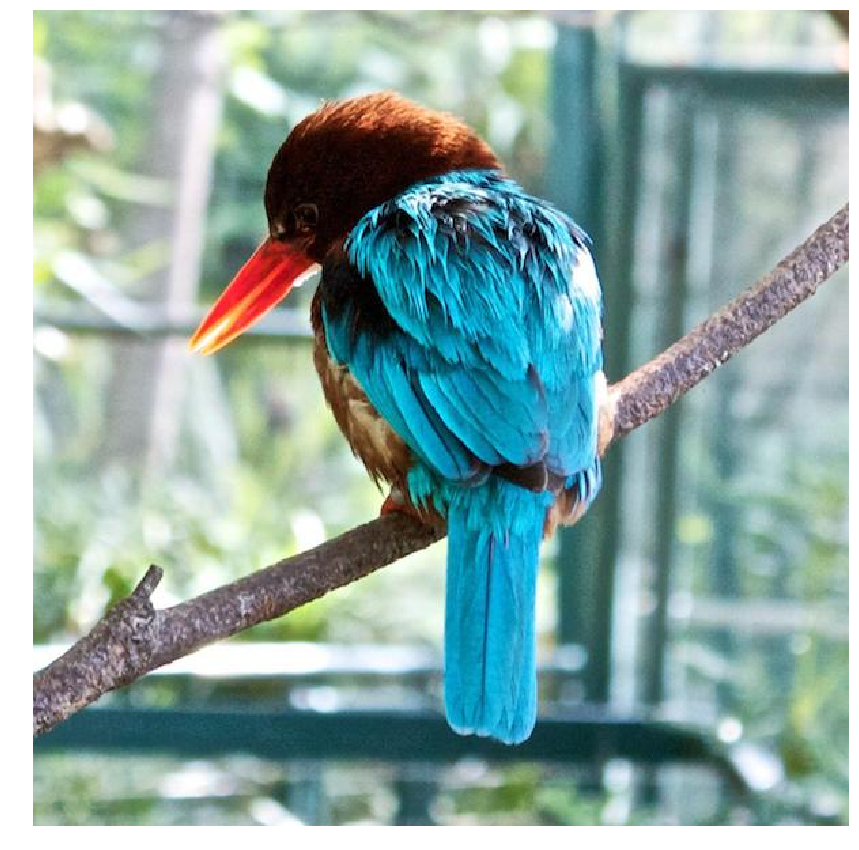

In [5]:
# Read input image
imgIn = cv2.imread("data/images/kingfisher.jpg")
    
# Output image is set to white
imgOut = 255 * np.ones(imgIn.shape, dtype = imgIn.dtype)

imshow(imgIn)

Next, the input and output triangles are defined as vector of 3 points each.

Finally, call `warpTriangle` to calculate the output image.

In [6]:
# Input triangle
triIn = np.float32([[[360,50], [60,100], [300,400]]])
  
# Output triangle
triOut = np.float32([[[400,200], [160,270], [400,400]]])
  
# Warp all pixels inside input triangle to output triangle
applyAffineTransform(imgIn, imgOut, triIn, triOut)

For display purposes, we are drawing the input triangle on the input image and output triangle on the output image using `cv::polylines`.

**Note**:

- We need to convert the images to `uint8` format before drawing the lines because pretty looking anti-aliased lines (specified using `lineType = cv2.LINE_AA`) are only supported for `uint8` images.
- `cv.polylines` takes as input a vector of type `uint8` and not `float32`. Hence a conversion is necessary.

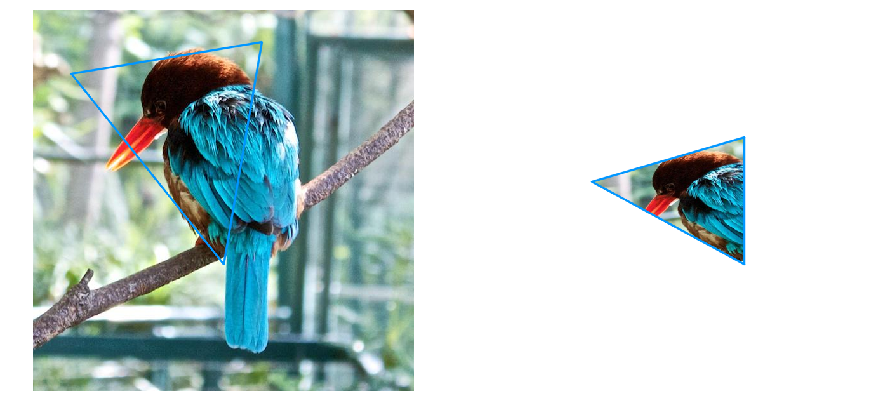

In [7]:
# Draw triangle using this color
color = (255, 150, 0)

# Draw triangles in input and output images.
cv2.polylines(imgIn, triIn.astype(int), True, color, 2, cv2.LINE_AA)
cv2.polylines(imgOut, triOut.astype(int), True, color, 2, cv2.LINE_AA)


imshow2(imgIn, imgOut)
